In [1]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = [os.path.join(PATH, "images/ds1"), os.path.join(PATH, "images/ds1/albumentated")]

images = []
labels = []

for si in SOURCE_IMAGES:
    images.extend(glob(os.path.join(si, "*.jpg")))
    labels.extend(glob(os.path.join(si.replace("images","labels"), "*.png")))

In [3]:
images.sort()
labels.sort()

In [4]:
print(np.size(images))
print(np.size(labels))

143
143


In [5]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)
    
del(images, labels, full_size_image, full_size_label)

In [6]:
x = np.asarray(x)
y = np.asarray(y)

In [7]:
print(y.min())
print(y.max())
print(x.shape)
print(y.shape)

0
8
(143, 1024, 1280, 3)
(143, 1024, 1280)


In [8]:
# Crop squared image
n_images, h, w = x.shape[0:3]

x = x[:,:,(w-h)//2:(w-(w-h)//2),:]
y = y[:,:,(w-h)//2:(w-(w-h)//2)]

n_images, h, w = x.shape[0:3]

print(x.shape)
print(y.shape)

(143, 1024, 1024, 3)
(143, 1024, 1024)


In [9]:
from sklearn.model_selection import train_test_split

test_size = 0.2
print("Train/test split: {}/{}\n".format(1-test_size,test_size))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)

del(x,y,x_train,y_train)

Train/test split: 0.8/0.2



In [10]:
print(x_test.shape)
print(y_test.shape)

(29, 1024, 1024, 3)
(29, 1024, 1024)


In [11]:
cs = ['background', 'asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

In [12]:
n_classes = len(cs)

from keras.utils import to_categorical

y_test = to_categorical(y_test, num_classes=n_classes)
y_test = y_test.reshape(x_test.shape[:3] + (n_classes,))
y_test.shape

/home/kenny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(29, 1024, 1024, 9)

In [13]:
y_test = y_test.astype('int8')

In [14]:
x_test = np.float32(x_test/255.)

In [15]:
from models.Unet import unet
from keras import optimizers

model = unet(input_size = [512,512,3], n_classes=n_classes)

learning_rate = 5e-5
optimizer = optimizers.Adam(lr = learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

model.load_weights('weights/2018-10-09 20:19:40.hdf5')

In [16]:
batch_size = 1

In [17]:
y_pred = np.zeros(y_test.shape)
y_pred = y_pred.astype('float32')

for i in range(len(x_test)):
    y_pred_temp = model.predict(np.array([x_test[i,:h//2,:w//2,:],
                                       x_test[i,:h//2,w//2:w,:], 
                                       x_test[i,h//2:h,:w//2,:], 
                                       x_test[i,h//2:h,w//2:w,:]]), batch_size=batch_size, verbose=1)
    y_pred[i,:h//2,:w//2,:] = y_pred_temp[0]
    y_pred[i,:h//2,w//2:w,:] = y_pred_temp[1]
    y_pred[i,h//2:h,:w//2,:] = y_pred_temp[2]
    y_pred[i,h//2:h,w//2:w,:] = y_pred_temp[3]

4/4 [==============================] - 15s 4s/step


In [18]:
import webcolors

hex_colors = ['#000000','#4A4A4A','#FF0000', '#407700', '#00FF37', '#8B572A', '#0000FF', '#FF7600', '#50E3C2']

rgb_colors = []

for hex_color in hex_colors:
    rgb_colors.append(webcolors.hex_to_rgb(hex_color))
    
def colorize(mask, colors):
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

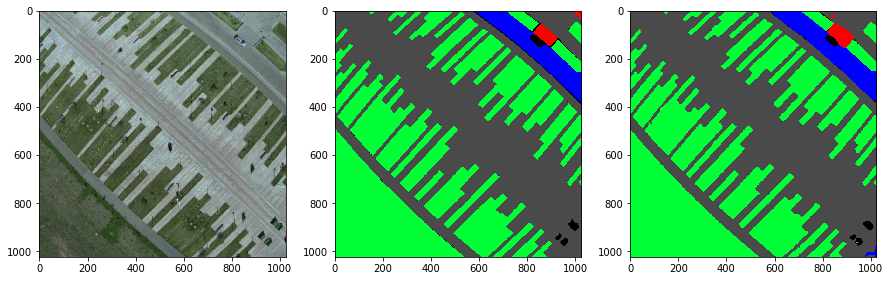

In [20]:
n = 0

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15,5)
axes[0].imshow(x_test[n])
axes[1].imshow(colorize(np.argmax(y_test[n],axis=-1), colors = np.array(rgb_colors)))
axes[2].imshow(colorize(np.argmax(y_pred[n],axis=-1), colors = np.array(rgb_colors)))

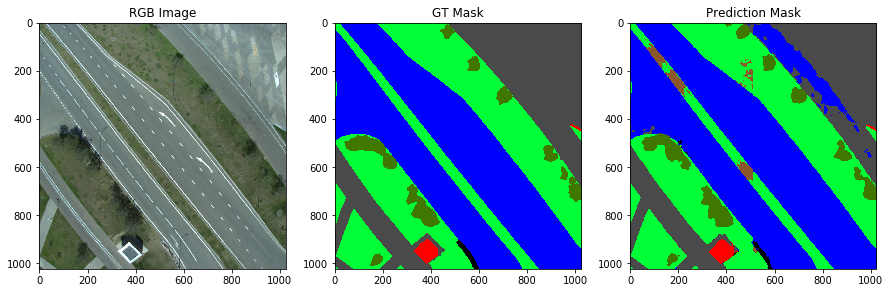

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15,5)
for i in range(len(x_test)):
    axes[0].set_title('RGB Image')
    axes[1].set_title('GT Mask')
    axes[2].set_title('Prediction Mask')
    axes[0].imshow(x_test[i])
    axes[1].imshow(colorize(np.argmax(y_test[i],axis=-1), colors = np.array(rgb_colors)))
    axes[2].imshow(colorize(np.argmax(y_pred[i],axis=-1), colors = np.array(rgb_colors)))
    fig.savefig('results/final_fullsize/img{}.png'.format(i))